#House Keeping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import time
import gc

use_cuda = True
use_colab_tpu = True
colab_tpu_available = False

if use_colab_tpu:
    try:
        assert os.environ['COLAB_TPU_ADDR']
        colab_tpu_available = True
    except:
        colab_tpu_available = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
    use_pin_memory = True
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))

elif use_colab_tpu and colab_tpu_available:
    import torch_xla
    import torch_xla.core.xla_model as xm
    torch_device = xm.xla_device()
    print("doing nothing")
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False
torch.set_default_device(torch_device)


wind = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/MergedWindData.pkl")

#chop off the last row and last column to make grid 700*400, this makes slicing the dataframe much easier!
min_range_y =-200
max_range_y =200
min_range_x =-350
max_range_x =350

wind = wind[wind['Points_0']<=max_range_x][wind['Points_0']>min_range_x][wind['Points_2']<=max_range_y][wind['Points_2']>min_range_y]

shape=(len(wind['Points_2'].unique()), len(wind['Points_0'].unique()))
print("wind shape", shape)


Mounted at /content/drive
CUDA Device Name: Tesla T4


<ipython-input-1-aa90885e6ff5>:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wind = wind[wind['Points_0']<=max_range_x][wind['Points_0']>min_range_x][wind['Points_2']<=max_range_y][wind['Points_2']>min_range_y]
<ipython-input-1-aa90885e6ff5>:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wind = wind[wind['Points_0']<=max_range_x][wind['Points_0']>min_range_x][wind['Points_2']<=max_range_y][wind['Points_2']>min_range_y]


wind shape (400, 700)


#Models

PINN and FCNN model

In [ ]:
size = 30
nu=0.0
gravity = 9.81

class PINN_NS():
    def __init__(self, loss="MSE"):
        print("\nNew object initializing")
        self.network()

        if loss=="MSE":
          self.loss_func = nn.MSELoss()
          self.loss_pow=2
        else:
          self.loss_func = nn.L1Loss()
          self.loss_pow=1

        self.val_loss_func = nn.L1Loss()
        self.loss = 0
        self.loss_hist = []
        self.val_hist = []
        self.uvw_loss = 0
        self.fg_loss = 0
        self.epoch=0
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(), lr=1.0, max_iter=100, max_eval=None, tolerance_grad=1e-11,
            tolerance_change=1e-9, history_size=100, line_search_fn="strong_wolfe") #history_size=200
        print("\tNew Optimizer Created.")



        self.means =  torch.tensor([0, 0, -43.78, 0, 0, 12.3, -2.58, 0.29, 3.6], dtype=torch.float32)
        self.scaling_factors =torch.tensor(np.array((32,16,1,16,1,32,50,16,200)), dtype=torch.float32)

    def network(self):
        print("New network created")
        self.net = nn.Sequential(
            nn.Linear(5,size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),

            nn.Linear(size, 4)
        )

    def function(self, x, y, z, angle, angle_diff):

        res = self.net(torch.hstack((x, y, z, angle, angle_diff)))
        u, v, w, p_star = res[:, 0:1], res[:, 1:2], res[:, 2:3] , res[:, 3:4]

        if self.use_c or self.use_m:
            u_x  = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            v_y  = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            w_z  = torch.autograd.grad(w, z, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        if self.use_c:
            # add considrartion of continuty (mass conservation equation)
            c = u_x*self.scaling_factors[5]/self.scaling_factors[0] +\
                v_y*self.scaling_factors[6]/self.scaling_factors[1] +\
                w_z*self.scaling_factors[7]/self.scaling_factors[2]
            self.c =self.lambda_c*c
        else:
           self.c = self.null

        if self.use_m:
            # compute the u gradients
            u_y  = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            u_z  = torch.autograd.grad(u, z, grad_outputs=torch.ones_like(u), create_graph=True)[0]

            # compute the v gradients
            v_x  = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            v_z  = torch.autograd.grad(v, z, grad_outputs=torch.ones_like(u), create_graph=True)[0]

            # compute w gradients
            w_x  = torch.autograd.grad(w, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            w_y  = torch.autograd.grad(w, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

            #compute second partial derivatives
            u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
            u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            u_zz = torch.autograd.grad(u_z, z, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            v_zz = torch.autograd.grad(v_z, z, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            w_xx = torch.autograd.grad(w_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            w_yy = torch.autograd.grad(w_y, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            w_zz = torch.autograd.grad(w_z, z, grad_outputs=torch.ones_like(u), create_graph=True)[0]


            # compute the modified pressure gradients
            p_x  = torch.autograd.grad(p_star, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]*self.scaling_factors[8]/self.scaling_factors[0]
            p_y  = torch.autograd.grad(p_star, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]*self.scaling_factors[8]/self.scaling_factors[1]
            #p_z  = torch.autograd.grad(p_star, z, grad_outputs=torch.ones_like(u), create_graph=True)[0]*self.scaling_factors[8]/self.scaling_factors[2]


            #momentume in x, y, z directions. I set u_t =0 since our model is assumed steady-state
            m_x = (u*self.scaling_factors[5]+self.means[5]) * u_x*self.scaling_factors[5]/self.scaling_factors[0] +\
                  (v*self.scaling_factors[6]+self.means[6]) * u_y*self.scaling_factors[5]/self.scaling_factors[1] +\
                  (w*self.scaling_factors[7]+self.means[7]) * u_z*self.scaling_factors[5]/self.scaling_factors[2] +\
                  p_x #-\
                  #nu * (u_xx*self.scaling_factors[5]/self.scaling_factors[0]**2 +\
                  #      u_yy*self.scaling_factors[5]/self.scaling_factors[1]**2 +\
                  #      u_zz*self.scaling_factors[5]/self.scaling_factors[2]**2)

            m_y = (u*self.scaling_factors[5]+self.means[5]) * v_x*self.scaling_factors[6]/self.scaling_factors[0] +\
                  (v*self.scaling_factors[6]+self.means[6]) * v_y*self.scaling_factors[6]/self.scaling_factors[1] +\
                  (w*self.scaling_factors[7]+self.means[7]) * v_z*self.scaling_factors[6]/self.scaling_factors[2] +\
                  p_y #-\
                 #nu * (v_xx*self.scaling_factors[6]/self.scaling_factors[0] +\
                 #      v_yy*self.scaling_factors[6]/self.scaling_factors[1] +\
                 #      v_zz*self.scaling_factors[6]/self.scaling_factors[2])

            m_z =(u*self.scaling_factors[5]+self.means[5]) * w_x*self.scaling_factors[7]/self.scaling_factors[0] +\
                 (v*self.scaling_factors[6]+self.means[6]) * w_y*self.scaling_factors[7]/self.scaling_factors[1] +\
                 (w*self.scaling_factors[7]+self.means[7]) * w_z*self.scaling_factors[7]/self.scaling_factors[2] +\
                  p_z - gravity# - \
                 #nu * (w_xx*self.scaling_factors[7]/self.scaling_factors[0] +\
                 #      w_yy*self.scaling_factors[7]/self.scaling_factors[1] +\
                 #      w_zz*self.scaling_factors[7]/self.scaling_factors[2])


            self.mx=m_x
            self.my=m_y
            self.mz=self.null
        else:
            self.mx = self.my = self.mz = self.null
        return u, v, w, p_star, self.c, self.mx, self.my, self.mz

    def closure(self):
        self.optimizer.zero_grad()

        u_pred, v_pred, w_pred, p_pred, c_pred, m_x_pred, m_y_pred, m_z_pred = self.function(self.x, self.y, self.z, self.angle, self.angle_diff)
        self.pi_null = torch.zeros((m_x_pred.shape[0], 1))

        if self.use_data:
            u_loss = self.loss_func(u_pred[:self.len], self.u)*self.scaling_factors[5]
            v_loss = self.loss_func(v_pred[:self.len], self.v)*self.scaling_factors[6]
            w_loss = self.loss_func(w_pred[:self.len], self.w)*self.scaling_factors[7]
            self.uvw_loss = u_loss + v_loss + w_loss
            self.p_loss = self.lambda_p*self.loss_func(p_pred[:self.len], self.p_star)*self.scaling_factors[7]
        else:
            self.uvw_loss = 0
            self.p_loss = 0

        if self.use_m:
            self.pi_null = torch.zeros((m_x_pred.shape[0], 1))
            m_x_loss = self.loss_func(m_x_pred, self.pi_null) #do scaling factors need to be included here?
            m_y_loss = self.loss_func(m_y_pred, self.pi_null)
            #m_z_loss = self.loss_func(m_z_pred, self.pi_null)
            self.m_loss = self.lambda_m*(2*m_x_loss + m_y_loss)
        else:
            self.m_loss = 0

        if self.use_c:
            self.pi_null = torch.zeros((c_pred.shape[0], 1))
            self.c_loss = self.loss_func(c_pred, self.pi_null)
        else:
            self.c_loss = 0


        self.loss = self.uvw_loss + self.p_loss + self.c_loss + self.m_loss #  ####change this back!

        self.validate()

        self.loss.backward()
        self.epoch += 1
        if not self.epoch%100:
            print('Epoch: {:}, Loss: {:0.6f},\tValidation Loss: {:0.6f}, \tUVW Loss: {:0.6f}, \tP Loss: {:0.6f}, \tC Loss: {:0.6f}, M Loss: {:0.6f}'.format(self.epoch, self.loss, self.val_loss, self.uvw_loss, self.p_loss, self.c_loss,  self.m_loss))

        self.loss_hist.append(self.loss.item())

        return self.loss

    def validate(self):

        res = self.net(torch.hstack((self.val_x, self.val_y, self.val_z, self.val_angle, self.val_angle_diff)))
        u_pred, v_pred, w_pred, p_pred = res[:, 0:1], res[:, 1:2], res[:, 2:3] , res[:, 3:4]

        u_loss = self.val_loss_func(u_pred, self.val_u)*self.scaling_factors[5]
        v_loss = self.val_loss_func(v_pred, self.val_v)*self.scaling_factors[6]
        w_loss = self.val_loss_func(w_pred, self.val_w)*self.scaling_factors[7]
        #p_loss = self.val_loss_func(p_pred, self.val_p_star)

        self.val_loss = (u_loss + v_loss + w_loss) # + p_loss
        self.val_hist.append(self.val_loss.item())


    def load_training_data(self, X, Y, Z, angle, angle_diff, U, V, W, P_star, angles_used):

        #Scaling the data
        data = torch.tensor(np.hstack((X, Y, Z, angle, angle_diff, U, V, W, P_star)), dtype=torch.float32)
        data = (data - self.means)/self.scaling_factors

        #Saving the scaled data
        self.x, self.y, self.z, self.angle, self.angle_diff, self.u, self.v, self.w, self.p_star = torch.split(data, 1, dim=1)
        self.x.requires_grad_()
        self.y.requires_grad_()
        self.z.requires_grad_()
        self.deg = angles_used
        self.null = torch.zeros((self.x.shape[0], 1))
        self.len = self.x.shape[0]


    def load_pinn_data(self, X, Y, Z, angle, angle_diff):
        data = torch.tensor(np.hstack((X, Y, Z, angle, angle_diff)), dtype=torch.float32)
        data = (data - self.means[:5])/self.scaling_factors[:5]
        self.p_x, self.p_y, self.p_z, self.p_angle, self.p_angle_diff = torch.split(data, 1, dim=1)
        self.x          = torch.cat((self.x, self.p_x), dim=0)
        self.y          = torch.cat((self.y, self.p_y), dim=0)
        self.z          = torch.cat((self.z, self.p_x), dim=0)
        self.angle      = torch.cat((self.angle, self.p_angle), dim=0)
        self.angle_diff = torch.cat((self.angle_diff, self.p_angle_diff), dim=0)




    def load_validaiton_data(self, X, Y, Z, angle, angle_diff, U, V, W, P_star, angles_used):
        print("Loading new validation tensors...")
        data = torch.tensor(np.hstack((X, Y, Z, angle, angle_diff, U, V, W, P_star)), dtype=torch.float32)
        data = (data - self.means)/self.scaling_factors

        #Saving the scaled data
        self.val_x, self.val_y, self.val_z, self.val_angle, self.val_angle_diff, self.val_u, self.val_v, self.val_w, self.val_p_star = torch.split(data, 1, dim=1)
        self.val_deg = angles_used
        self.val_null = torch.zeros((self.val_x.shape[0], 1))
        self.val_loss =0
        print("New validation tensors Loaded!\n")

    def predict(self, x, y, z, angle, angle_diff, shape=shape):

        data = torch.tensor(np.hstack((x, y, z, angle, angle_diff)), dtype=torch.float32)
        data = (data - self.means[:5])/self.scaling_factors[:5]
        res = self.net(data)*self.scaling_factors[-4:] +self.means[-4:]

        return tuple([i.data.cpu().numpy().reshape(shape) for i in res.split(1, dim=1)])



    def train(self, epochs=100, use_c=True,use_m=True, use_data=True, lr=0.2, skip_n=1,  p=0.015, c=30, m=0.03, skip_fraction=0/9):
        print("Beginning Training..")
        start_time = time.time()
        self.use_c = use_c
        self.use_m = use_m
        self.use_data = use_data
        self.skip_n = skip_n
        self.lambda_p = p
        self.lambda_c = c
        self.lambda_m = m
        self.skip_fraction = skip_fraction
        for group in self.optimizer.param_groups:
          group['max_iter']=epochs
          group['max_eval']=epochs
          group['lr']=lr

        if self.skip_n!=1:
          print("Skipping every", skip_n, "data points.")

        print("Traing:\tUse Data=", self.use_data,
              "Traing:\tUse Momentum Eqs=", self.use_m,
              "\tUse Mass Conservation=", self.use_c,
              "\tEpochs = ", self.optimizer.param_groups[0]['max_iter'],
              "\tLearning Rate = ", self.optimizer.param_groups[0]['lr'],)
        print("\tTraining angles = ",self.deg, "\tValidation angles =", self.val_deg)
        print("nu = ", nu)


        self.net.train()
        self.optimizer.step(self.closure)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"\nTraining complete.\tElapsed time: {int(elapsed_time)} seconds")


    def get_loss(self):
        return self.loss_hist, self.val_hist

Fourier Feature Layer Models

In [ ]:

new_var = nu=0.115
gravity = 9.81


class ScaleAndShiftLayer(nn.Module):
    def __init__(self, scale_factors, means):
        super(ScaleAndShiftLayer, self).__init__()
        self.scale_factors = torch.tensor(scale_factors, dtype=torch.float32)# nn.Parameter(torch.ones(4))
        self.means = torch.tensor(means, dtype=torch.float32)# nn.Parameter(torch.ones(4))

    def forward(self, x):
        return x * self.scale_factors + self.means

class TrainableFourierFeatureMap(nn.Module):
    def __init__(self, num_bins, b_scales = [0.0015, 0.003, 0.15, 1/80,1]):
        super(TrainableFourierFeatureMap, self).__init__()
        #self.B = nn.Parameter(torch.randn(3, num_bins))
        self.B = torch.randn(5, num_bins)*2*np.pi*torch.tensor(b_scales, dtype=torch.float32).unsqueeze(-1)

        #new optimization
        #self.B = torch.cat([self.B, torch.ones(num_bins, dtype=torch.float32).unsqueeze(0), torch.ones(num_bins, dtype=torch.float32).unsqueeze(0)])

    def forward(self, x):

        x_proj = x @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

        # Apply Fourier transformation
        #x_proj = x[:,:3] @ self.B
        #x_fourier = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

        # Concatenate the transformed and untransformed parts
        #return  torch.cat([x_fourier, x[:,3:]], dim=-1)

        #optimization code
        #return  torch.cat([torch.sin(x_proj), torch.cos(x_proj), x[:,3:]], dim=-1)


class PINN_NS_Fourier():
    def __init__(self, loss="MSE", bins = 50, b_scales = [0.0012, 0.003, 0.15, 1/80,1]): #b_scales = [0.0015, 0.003, 0.15]
        print("\nNew object initializing")

        size=bins*2
        self.network(size, b_scales, [32.,  50.,  30., 220.],[0, -2.97, 0.25, 4.5623])  ###I think these scale factors need fixing# means?? 13.6, 0., 0.,  4.0

        if loss=="MSE":
          self.loss_func = nn.MSELoss()
          self.loss_pow=2
        else:
          self.loss_func = nn.L1Loss()
          self.loss_pow=1

        self.val_loss_func = nn.L1Loss()
        self.loss = 0
        self.loss_hist = []
        self.val_hist = []
        self.uvw_loss = 0
        self.fg_loss = 0
        self.epoch=0
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(), lr=1.0, max_iter=100, max_eval=None, tolerance_grad=1e-12,
            tolerance_change=1e-12, history_size=100, line_search_fn="strong_wolfe")
        print("\tNew Optimizer Created.")


    def network(self, bins, b_scale, scale_factors, constants):
        print("New network created")
        size = bins*2
        self.net = nn.Sequential(
            TrainableFourierFeatureMap(bins, b_scale),
            nn.Linear(size,size), nn.Tanh(),
            nn.Linear(size,size), nn.Tanh(),
            nn.Linear(size,size), nn.Tanh(),
            nn.Linear(size,size), nn.Tanh(),
            nn.Linear(size,size), nn.Tanh(),
            nn.Linear(size,size), nn.Tanh(),
            nn.Linear(size,size), nn.Tanh(),
            nn.Linear(size,size), nn.Tanh(),
            nn.Linear(size,size), nn.Tanh(),
            nn.Linear(size, 4),
            ScaleAndShiftLayer(scale_factors, constants)
        )

    def function(self, x, y, z, angle, angle_diff):

        res = self.net(torch.hstack((x, y, z, angle, angle_diff)))
        u, v, w, p_star = res[:, 0:1], res[:, 1:2], res[:, 2:3] , res[:, 3:4]

        if self.use_c or self.use_m:
            u_x  = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            v_y  = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            w_z  = torch.autograd.grad(w, z, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        if self.use_c:
            # add considrartion of continuty (mass conservation equation)
            self.c =self.lambda_c*(u_x + v_y + w_z)
        else:
           self.c = self.null

        if self.use_m:
            # compute the u gradients
            u_y  = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            u_z  = torch.autograd.grad(u, z, grad_outputs=torch.ones_like(u), create_graph=True)[0]

            # compute the v gradients
            v_x  = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            v_z  = torch.autograd.grad(v, z, grad_outputs=torch.ones_like(u), create_graph=True)[0]

            # compute w gradients
            w_x  = torch.autograd.grad(w, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            w_y  = torch.autograd.grad(w, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

            #compute second partial derivatives
            u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
            u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            u_zz = torch.autograd.grad(u_z, z, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            v_zz = torch.autograd.grad(v_z, z, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            #w_xx = torch.autograd.grad(w_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            #w_yy = torch.autograd.grad(w_y, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            #w_zz = torch.autograd.grad(w_z, z, grad_outputs=torch.ones_like(u), create_graph=True)[0]


            # compute the modified pressure gradients
            p_x  = torch.autograd.grad(p_star, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            p_y  = torch.autograd.grad(p_star, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            p_z  = torch.autograd.grad(p_star, z, grad_outputs=torch.ones_like(u), create_graph=True)[0]


            #momentume in x, y, z directions. I set u_t =0 since our model is assumed steady-state
            m_x = u*u_x + v*u_y + w*u_z + p_x - nu * (u_xx + u_yy + u_zz)
            m_y = u*v_x + v*v_y + w*v_z + p_y - nu * (v_xx + v_yy + v_zz)
            #m_z = u*w_x + v*w_y + w*w_z + p_z - nu * (w_xx + w_yy + w_zz) - g
            self.mx=m_x
            self.my=m_y
            self.mz=self.null
        else:
            self.mx = self.my = self.mz = self.null
        return u, v, w, p_star, self.c, self.mx, self.my, self.mz

    def closure(self):
        self.optimizer.zero_grad()
        u_pred, v_pred, w_pred, p_pred, c_pred, m_x_pred, m_y_pred, m_z_pred = self.function(self.x, self.y, self.z, self.angle, self.angle_diff)

        if self.use_data:
            u_loss = self.loss_func(u_pred[:self.len], self.u)
            v_loss = self.loss_func(v_pred[:self.len], self.v)
            w_loss = self.loss_func(w_pred[:self.len], self.w)
            self.uvw_loss = u_loss + v_loss + w_loss
            self.p_loss = self.lambda_p*self.loss_func(p_pred[:self.len], self.p_star)
        else:
            self.uvw_loss = 0
            self.p_loss = 0

        if self.use_m:
            self.pi_null = torch.zeros((m_x_pred.shape[0], 1))
            m_x_loss = self.loss_func(m_x_pred, self.pi_null) #do scaling factors need to be included here?
            m_y_loss = self.loss_func(m_y_pred, self.pi_null)
            #m_z_loss = self.loss_func(m_z_pred, self.pi_null)
            self.m_loss = self.lambda_m*(2*m_x_loss + m_y_loss)
        else:
            self.m_loss = 0

        if self.use_c:
            self.pi_null = torch.zeros((c_pred.shape[0], 1))
            self.c_loss = self.loss_func(c_pred, self.pi_null)
        else:
            self.c_loss = 0

        self.loss = self.uvw_loss + self.p_loss + self.c_loss + self.m_loss

        self.validate()

        self.loss.backward()
        self.epoch += 1
        if not self.epoch%100:
            print('Epoch: {:}, Loss: {:0.3f},\tValidation Loss: {:0.3f}, \tUVW Loss: {:0.3f}, \tP Loss: {:0.3f}, \tC Loss: {:0.3f}, M Loss: {:0.3f}'.format(self.epoch, self.loss, self.val_loss, self.uvw_loss, self.p_loss, self.c_loss,  self.m_loss))

        self.loss_hist.append(self.loss.item())

        return self.loss

    def validate(self):
        val_data = torch.hstack((self.val_x, self.val_y, self.val_z, self.val_angle, self.val_angle_diff))

        res = self.net(val_data)

        u_pred, v_pred, w_pred, p_pred = res[:, 0:1], res[:, 1:2], res[:, 2:3] , res[:, 3:4]

        u_loss = self.val_loss_func(u_pred, self.val_u)
        v_loss = self.val_loss_func(v_pred, self.val_v)
        w_loss = self.val_loss_func(w_pred, self.val_w)
        #p_loss = self.val_loss_func(p_pred, self.val_p_star)

        self.val_loss = (u_loss + v_loss + w_loss) # + p_loss
        self.val_hist.append(self.val_loss.item())


    def load_training_data(self, X, Y, Z, angle, angle_diff, U, V, W, P_star, angles_used):
        print("Loading new training tensors...")

        data = torch.tensor(np.hstack((X, Y, Z, angle, angle_diff, U, V, W, P_star)), dtype=torch.float32)

        #Saving the tensor data
        self.x, self.y, self.z, self.angle, self.angle_diff, self.u, self.v, self.w, self.p_star = data.split(1, dim=1)
        self.x.requires_grad_()
        self.y.requires_grad_()
        self.z.requires_grad_()
        self.deg = angles_used
        self.null = torch.zeros((self.x.shape[0], 1))
        self.len = self.x.shape[0]

    def load_pinn_data(self, X, Y, Z, angle, angle_diff):
        data = torch.tensor(np.hstack((X, Y, Z, angle, angle_diff)), dtype=torch.float32)
        self.p_x, self.p_y, self.p_z, self.p_angle, self.p_angle_diff = torch.split(data, 1, dim=1)
        self.x          = torch.cat((self.x, self.p_x), dim=0)
        self.y          = torch.cat((self.y, self.p_y), dim=0)
        self.z          = torch.cat((self.z, self.p_x), dim=0)
        self.angle      = torch.cat((self.angle, self.p_angle), dim=0)
        self.angle_diff = torch.cat((self.angle_diff, self.p_angle_diff), dim=0)

    def load_validaiton_data(self, X, Y, Z, angle, angle_diff, U, V, W, P_star, angles_used):
        print("Loading new validation tensors...")
        data = torch.tensor(np.hstack((X, Y, Z, angle, angle_diff, U, V, W, P_star)), dtype=torch.float32)

        #Saving the scaled data
        self.val_x, self.val_y, self.val_z, self.val_angle, self.val_angle_diff, self.val_u, self.val_v, self.val_w, self.val_p_star = torch.split(data, 1, dim=1)
        self.val_deg = angles_used
        self.val_null = torch.zeros((self.val_x.shape[0], 1))
        self.val_loss =0
        print("New validation tensors Loaded!\n")

    def predict(self, x, y, z, angle, angle_diff, shape=shape):
        data = torch.tensor(np.hstack((x, y, z, angle, angle_diff)), dtype=torch.float32)
        res = self.net(data)
        u, v, w, p = res[:, 0:1], res[:, 1:2], res[:, 2:3] , res[:, 3:4]
        return tuple([i.data.cpu().numpy().reshape(shape) for i in [u, v, w, p]])



    def train(self, epochs=100, use_c=True,use_m=True, use_data=True, lr=1.0,  p=0.015, c=30, m=0.03):
        print("Beginning Training..")
        start_time = time.time()
        self.use_c = use_c
        self.use_m = use_m
        self.use_data = use_data
        self.lambda_p = p
        self.lambda_c = c
        self.lambda_m = m
        for group in self.optimizer.param_groups:
          group['max_iter']=epochs
          group['max_eval']=epochs
          group['lr']=lr

        print("Traing:\tUse Data=", self.use_data,
              "Traing:\tUse Momentum Eqs=", self.use_m,
              "\tUse Mass Conservation=", self.use_c,
              "\tEpochs = ", self.optimizer.param_groups[0]['max_iter'],
              "\tLearning Rate = ", self.optimizer.param_groups[0]['lr'],)
        print("\tTraining angles = ",self.deg, "\tValidation angles =", self.val_deg)

        self.net.train()
        self.optimizer.step(self.closure)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"\nLowested Validation {np.min(self.val_hist)}.\tElapsed time: {int(elapsed_time)} seconds")
        #print(f"\nLowested Validation {np.min(sel.val_hist)}")

    def get_loss(self):
        return self.loss_hist, self.val_hist

#FCNN & PINN Model

In [ ]:
#del PINN
#del PINN_10_10
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

*preprocessed_data, angles = get_preprocessed_data([3,4,5,6,7,8,10,11])
data_len = preprocessed_data[0].shape[0]
percentage = 0.01
random_indices = torch.randperm(data_len)[:int(percentage * data_len)].cpu().numpy()
*preprocessed_val_data, val_angles = get_preprocessed_data([0,1,2,3,4,5,7,8,9,10,11,12])



*preprocessed_pinn_data, pinn_angles = get_preprocessed_data([0,1,2,3,4,5,7,8,9,10,11,12])
pinn_percent = 0.1
pinn_len = preprocessed_pinn_data[0].shape[0]
pinn_indices = torch.randperm(pinn_len)[:int(pinn_percent * pinn_len)].cpu().numpy()


##Model with PINN Data
PINN = PINN_NS(loss="L1") #create a new Model, loss="MSE"
PINN.load_training_data(*(i[random_indices] for i in preprocessed_data), angles)
PINN.load_pinn_data(*(i[pinn_indices] for i in preprocessed_pinn_data[:5]))
PINN.load_validaiton_data(*(i[::37] for i in preprocessed_val_data), val_angles)
PINN.train(use_c=False, use_m=False, use_data=True, lr=1, epochs=1000, c=0, m = 0.3, p=0.2)
PINN.train(use_c=True, use_m=False, use_data=True, lr=1, epochs=1000, c=20, m = 0.3, p=0.2)
PINN.train(use_c=True, use_m=False, use_data=True, lr=1, epochs=1000, c=30, m = 0.3, p=0.2)
PINN.train(use_c=True, use_m=False, use_data=True, lr=1, epochs=1000, c=40, m = 0.3, p=0.2)
PINN.train(use_c=True, use_m=False, use_data=True, lr=1, epochs=1000, c=50, m = 0.3, p=0.2)

#PINN.load_pinn_data(*(i[pinn_indices] for i in preprocessed_pinn_data[:5]))
#PINN.train(use_c=True, use_m=False, use_data=True, lr=0.2, epochs=4000, c=40, m = 0.3, p=0.2)

Getting preprocessed data for angles [-40, -30, -20, -10, 0, 10, 30, 40] °
Getting preprocessed data for angles [-70, -60, -50, -40, -30, -20, 0, 10, 20, 30, 40, 50] °
Getting preprocessed data for angles [-70, -60, -50, -40, -30, -20, 0, 10, 20, 30, 40, 50] °

New object initializing
New network created
	New Optimizer Created.
Loading new validation tensors...
New validation tensors Loaded!

Beginning Training..
Traing:	Use Data= True Traing:	Use Momentum Eqs= False 	Use Mass Conservation= False 	Epochs =  1000 	Learning Rate =  1
	Training angles =  [-40, -30, -20, -10, 0, 10, 30, 40] 	Validation angles = [-70, -60, -50, -40, -30, -20, 0, 10, 20, 30, 40, 50]
nu =  0.0
Epoch: 100, Loss: 5.545060,	Validation Loss: 6.358317, 	UVW Loss: 5.149749, 	P Loss: 0.395311, 	C Loss: 0.000000, M Loss: 0.000000
Epoch: 200, Loss: 4.902281,	Validation Loss: 5.089744, 	UVW Loss: 4.544747, 	P Loss: 0.357534, 	C Loss: 0.000000, M Loss: 0.000000
Epoch: 300, Loss: 4.604403,	Validation Loss: 4.825349, 	UVW

In [ ]:
PINN_staggered = PINN.val_hist

In [ ]:
*preprocessed_data, angles = get_preprocessed_data([3,4,5,6,7,8,10,11])
data_len = preprocessed_data[0].shape[0]
percentage = 0.01
random_indices = torch.randperm(data_len)[:int(percentage * data_len)].cpu().numpy()
*preprocessed_val_data, val_angles = get_preprocessed_data([0,1,2,3,4,5,7,8,9,10,11,12])



*preprocessed_pinn_data, pinn_angles = get_preprocessed_data([0,1,2,3,4,5,7,8,9,10,11,12])
pinn_percent = 0.1
pinn_len = preprocessed_pinn_data[0].shape[0]
pinn_indices = torch.randperm(pinn_len)[:int(pinn_percent * pinn_len)].cpu().numpy()

##Model with PINN Data all at once
PINN_2 = PINN_NS(loss="L1") #create a new Model, loss="MSE"
PINN_2.load_training_data(*(i[random_indices] for i in preprocessed_data), angles)
PINN_2.load_pinn_data(*(i[pinn_indices] for i in preprocessed_pinn_data[:5]))
PINN_2.load_validaiton_data(*(i[::37] for i in preprocessed_val_data), val_angles)
PINN_2.train(use_c=True, use_m=False, use_data=True, lr=1, epochs=5000, c=50, m = 0.3, p=0.2)


Getting preprocessed data for angles [-40, -30, -20, -10, 0, 10, 30, 40] °
Getting preprocessed data for angles [-70, -60, -50, -40, -30, -20, 0, 10, 20, 30, 40, 50] °
Getting preprocessed data for angles [-70, -60, -50, -40, -30, -20, 0, 10, 20, 30, 40, 50] °

New object initializing
New network created
	New Optimizer Created.
Loading new validation tensors...
New validation tensors Loaded!

Beginning Training..
Traing:	Use Data= True Traing:	Use Momentum Eqs= False 	Use Mass Conservation= True 	Epochs =  5000 	Learning Rate =  1
	Training angles =  [-40, -30, -20, -10, 0, 10, 30, 40] 	Validation angles = [-70, -60, -50, -40, -30, -20, 0, 10, 20, 30, 40, 50]
nu =  0.0
Epoch: 100, Loss: 6.108093,	Validation Loss: 6.732171, 	UVW Loss: 5.566843, 	P Loss: 0.438686, 	C Loss: 0.102564, M Loss: 0.000000
Epoch: 200, Loss: 5.475481,	Validation Loss: 5.951252, 	UVW Loss: 5.033754, 	P Loss: 0.339061, 	C Loss: 0.102665, M Loss: 0.000000
Epoch: 300, Loss: 5.106380,	Validation Loss: 5.204655, 	UVW 

In [ ]:
#Model with PINN Data
FCNN = PINN_NS(loss="L1") #create a new Model, loss="MSE"
FCNN.load_training_data(*(i[random_indices] for i in preprocessed_data), angles)
FCNN.load_validaiton_data(*(i[::37] for i in preprocessed_val_data), val_angles)
FCNN.train(use_c=False, use_m=False, use_data=True, lr=1, epochs=5000, c=40, m = 0.3, p=0.2)


New object initializing
New network created
	New Optimizer Created.
Loading new validation tensors...
New validation tensors Loaded!

Beginning Training..
Traing:	Use Data= True Traing:	Use Momentum Eqs= False 	Use Mass Conservation= False 	Epochs =  5000 	Learning Rate =  1
	Training angles =  [-40, -30, -20, -10, 0, 10, 30, 40] 	Validation angles = [-70, -60, -50, -40, -30, -20, 0, 10, 20, 30, 40, 50]
nu =  0.0
Epoch: 100, Loss: 5.731153,	Validation Loss: 6.423484, 	UVW Loss: 5.329349, 	P Loss: 0.401804, 	C Loss: 0.000000, M Loss: 0.000000
Epoch: 200, Loss: 4.977986,	Validation Loss: 5.296895, 	UVW Loss: 4.642175, 	P Loss: 0.335811, 	C Loss: 0.000000, M Loss: 0.000000
Epoch: 300, Loss: 4.679510,	Validation Loss: 5.010977, 	UVW Loss: 4.351223, 	P Loss: 0.328287, 	C Loss: 0.000000, M Loss: 0.000000
Epoch: 400, Loss: 4.485147,	Validation Loss: 4.731427, 	UVW Loss: 4.172128, 	P Loss: 0.313019, 	C Loss: 0.000000, M Loss: 0.000000
Epoch: 500, Loss: 4.339042,	Validation Loss: 4.568807, 	UV

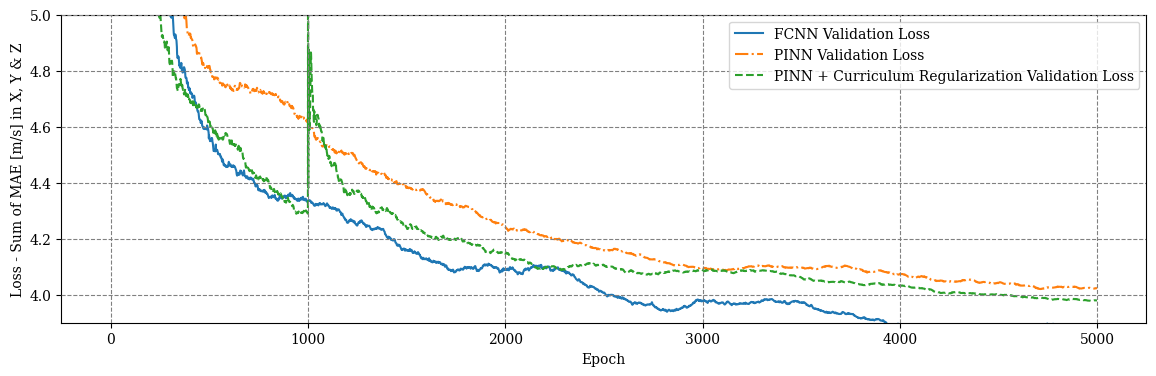

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.figure(figsize=(14,4))
b_scaling=[0.001,0.01,0.02,0.04,0.10,0.2,0.4]
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]  # Solid, dashed, dash-dot, dotted, custom



#No Physics Model
FCNN_hist, FCNN_val_hist = FCNN.get_loss()
PINN_hist, PINN_val_hist = PINN.get_loss()
P2NN_hist, PINN_val_hist_2 = PINN_2.get_loss()

plt.plot(FCNN_val_hist, label='FCNN Validation Loss', linestyle=linestyles[0])
plt.plot(PINN_val_hist_2, label='PINN Validation Loss', linestyle=linestyles[2])
plt.plot(PINN_val_hist, label='PINN + Curriculum Regularization Validation Loss', linestyle=linestyles[1])


#plt.xlim(0,2_000)
plt.ylim(3.9,5)
plt.grid()
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss - Sum of MAE [m/s] in X, Y & Z')
#plt.title('Loss curve - No Physics Model')
plt.legend(loc='upper right')
plt.grid(color='gray', linestyle='dashed')
plt.rc('axes', axisbelow=False)
plt.savefig("curriculum_regularization.svg", dpi=300)
#plt.show()

<Figure size 1400x400 with 0 Axes>

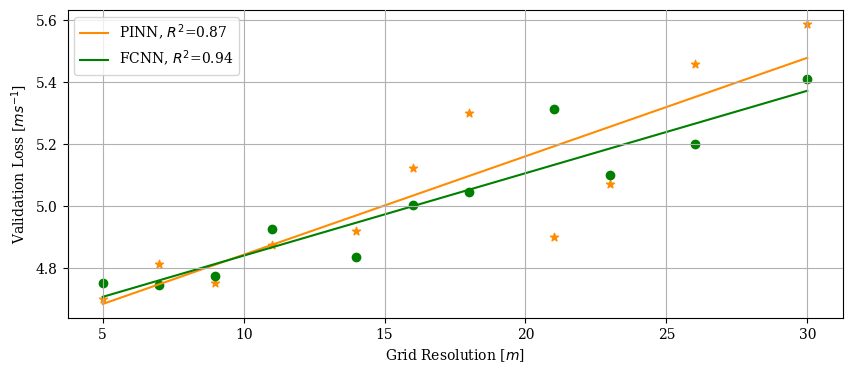

In [ ]:
fig = plt.figure(figsize=[14,4])
#ax = plt.subplot(111)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.figure(figsize=(10,4))

x = PINN_NADIR_results[0]
y = PINN_NADIR_results[1]

plt.scatter(x, y, color='darkorange', marker='*')
coefs = np.polyfit(x, y, 1)  # 2 for quadratic
p = np.poly1d(coefs)
y_smooth = p(x)
correlation_coefficient_pinn = np.corrcoef(x, y)[0, 1]
plt.plot(x, y_smooth, color='darkorange', label=f'PINN, $R^2$={correlation_coefficient_pinn:.2f}')



y2 = FCNN_NADIR_results[1]
plt.scatter(x, y2, color='green')
coefs2 = np.polyfit(x, y2, 1)  # 2 for quadratic
p2 = np.poly1d(coefs2)
y_smooth2 = p2(x)

correlation_coefficient_fcnn = np.corrcoef(x, y2)[0, 1]
plt.plot(x, y_smooth2, color='green', label=f'FCNN, $R^2$={correlation_coefficient_fcnn:.2f}')
plt.grid()

#plt.text(0.1, 0.9,, transform=plt.gca().transAxes)
#plt.text(0.1, 0.85, f'R^2: {r_squared:.2f}', transform=plt.gca().transAxes)

# Adding labels and title
plt.xlabel('Grid Resolution [$m$]')
plt.ylabel('Validation Loss [$ms^{-1}$]')
plt.legend()
#plt.savefig("skip_size_comparison.svg", format='svg', dpi=300)

In [ ]:
#M parameter finding!!

#*preprocessed_data, angles = get_preprocessed_data([3,6,8,11])
*preprocessed_data, angles = get_preprocessed_data([3,4,5,6,7,8,10,11])
*preprocessed_val_data, val_angles = get_preprocessed_data([0,1,2,3,4,5,7,8,9,10,11,12])
data_len = preprocessed_data[0].shape[0]

*preprocessed_pinn_data, pinn_angles = get_preprocessed_data([0,1,2,3,4,5,7,8,9,10,11,12])

percentage = 0.003
random_indices = torch.randperm(data_len)[:int(percentage * data_len)].cpu().numpy()

pinn_percent = 0.07
pinn_len = preprocessed_data[0].shape[0]
pinn_indices = torch.randperm(pinn_len)[:int(pinn_percent * pinn_len)].cpu().numpy()

data_len = preprocessed_data[0].shape[0]

m_NADIR_list = []
m_vals = np.linspace(0, 0.5, 12)
for i in m_vals:

    print("m = ", i)


    ##Model with PINN Data
    PINN = PINN_NS(loss="L1") #create a new Model, loss="MSE"
    PINN.load_training_data(*(i[random_indices] for i in preprocessed_data), angles)
    PINN.load_pinn_data(*(i[pinn_indices] for i in preprocessed_pinn_data[:5]))
    PINN.load_validaiton_data(*(i[::23] for i in preprocessed_val_data), val_angles)
    PINN.train(use_c=True, use_m=True, use_data=True, lr=0.2, epochs=2000, c=40, m = i, p=0.2)

    m_NADIR_list.append(np.min(PINN.val_hist))
    #print("min value: ", np.min(PINN_10_10.val_hist))


    del PINN
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.memory_allocated()

m_NADIR_results = (m_vals, m_NADIR_list)
print(m_NADIR_results)

Getting preprocessed data for angles [-40, -30, -20, -10, 0, 10, 30, 40] °
Getting preprocessed data for angles [-70, -60, -50, -40, -30, -20, 0, 10, 20, 30, 40, 50] °
Getting preprocessed data for angles [-70, -60, -50, -40, -30, -20, 0, 10, 20, 30, 40, 50] °
m =  0.0

New object initializing
New network created
	New Optimizer Created.
Loading new validation tensors...
New validation tensors Loaded!

Beginning Training..
Traing:	Use Data= True Traing:	Use Momentum Eqs= True 	Use Mass Conservation= True 	Epochs =  2000 	Learning Rate =  0.2
	Training angles =  [-40, -30, -20, -10, 0, 10, 30, 40] 	Validation angles = [-70, -60, -50, -40, -30, -20, 0, 10, 20, 30, 40, 50]
nu =  0.0
Epoch: 100, Loss: 4.060367,	Validation Loss: 3.595898, 	UVW Loss: 3.140372, 	P Loss: 0.857249, 	C Loss: 0.062746, M Loss: 0.000000
Epoch: 200, Loss: 3.265774,	Validation Loss: 2.915145, 	UVW Loss: 2.625426, 	P Loss: 0.591261, 	C Loss: 0.049087, M Loss: 0.000000
Epoch: 300, Loss: 3.076233,	Validation Loss: 2.749

KeyboardInterrupt: 

<Figure size 1400x400 with 0 Axes>

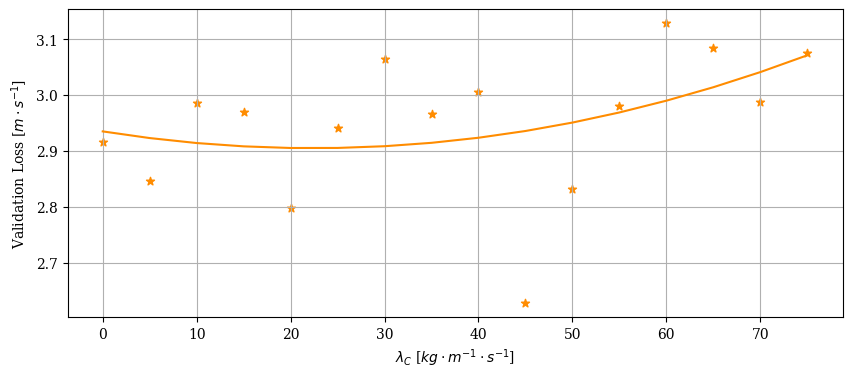

In [ ]:
fig = plt.figure(figsize=[14,4])
#ax = plt.subplot(111)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.figure(figsize=(10,4))

x = c_NADIR_results[0].tolist() + [55,60,65, 70, 75]
y = c_NADIR_list

plt.scatter(x, y, color='darkorange', marker='*')
coefs = np.polyfit(x, y, 2)  # 2 for quadratic
p = np.poly1d(coefs)
y_smooth = p(x)
plt.plot(x, y_smooth, color='darkorange', label='PINN')



plt.grid()

# Adding labels and title
plt.xlabel('$\\lambda_{C}$ [$kg\cdot m^{-1}\cdot s^{-1}$]')
plt.ylabel('Validation Loss [$m\cdot s^{-1}$]')
#plt.legend()
plt.savefig("lambda_c_optimization.svg", format='svg', dpi=300)

# Fourier Experiments

In [ ]:
#*preprocessed_data, angles = get_preprocessed_data([3,4,5,6,7,8,10,11])
#*preprocessed_val_data, val_angles = get_preprocessed_data([0,1,2,9,12])
#percentage = 0.005
#data_len = preprocessed_data[0].shape[0]
#random_indices = torch.randperm(data_len)[:int(percentage * data_len)].cpu().numpy()
#
#*preprocessed_pinn_data, pinn_angles = get_preprocessed_data([0,1,2,3,4,5,7,8,9,10,11,12])
#pinn_percent = 0.06
#pinn_len = preprocessed_data[0].shape[0]
#pinn_indices = torch.randperm(pinn_len)[:int(pinn_percent * pinn_len)].cpu().numpy()
#
#
#FF_FCNN = PINN_NS_Fourier(loss="L1",bins = 30, b_scales=[0.0016, 0.0016, 0.0048, 0.0027, 0.027]) #create a new Model, loss="MSE"
#FF_FCNN.load_training_data(*(i[random_indices] for i in preprocessed_data), angles)
##F_PINN.load_pinn_data(*(i[pinn_indices] for i in preprocessed_pinn_data[:5]))
#FF_FCNN.load_validaiton_data(*(i[::69] for i in preprocessed_val_data), val_angles)
FF_FCNN.train(use_c=False, use_m=False, use_data=True, lr=1, epochs=1000, c=40, m = 0.0, p=0.0)

Beginning Training..
Traing:	Use Data= True Traing:	Use Momentum Eqs= False 	Use Mass Conservation= False 	Epochs =  1000 	Learning Rate =  1
	Training angles =  [-40, -30, -20, -10, 0, 10, 30, 40] 	Validation angles = [-70, -60, -50, 20, 50]
Epoch: 1100, Loss: 2.381,	Validation Loss: 5.681, 	UVW Loss: 2.381, 	P Loss: 0.000, 	C Loss: 0.000, M Loss: 0.000
Epoch: 1200, Loss: 2.312,	Validation Loss: 5.619, 	UVW Loss: 2.312, 	P Loss: 0.000, 	C Loss: 0.000, M Loss: 0.000
Epoch: 1300, Loss: 2.244,	Validation Loss: 5.635, 	UVW Loss: 2.244, 	P Loss: 0.000, 	C Loss: 0.000, M Loss: 0.000
Epoch: 1400, Loss: 2.180,	Validation Loss: 5.805, 	UVW Loss: 2.180, 	P Loss: 0.000, 	C Loss: 0.000, M Loss: 0.000
Epoch: 1500, Loss: 2.123,	Validation Loss: 5.886, 	UVW Loss: 2.123, 	P Loss: 0.000, 	C Loss: 0.000, M Loss: 0.000
Epoch: 1600, Loss: 2.073,	Validation Loss: 5.938, 	UVW Loss: 2.073, 	P Loss: 0.000, 	C Loss: 0.000, M Loss: 0.000
Epoch: 1700, Loss: 2.022,	Validation Loss: 6.022, 	UVW Loss: 2.022, 	P Lo

KeyboardInterrupt: 

In [ ]:
for i in range(0,13):
  FF_FCNN.load_validaiton_data(*(i for i in get_preprocessed_data([i])))
  FF_FCNN.validate()


#categories = ['-70°', '-60°','-50°','-40°','-30°','-20°','-10°','0°','10°','20°','30°','40°','50°']

FF_FCNN_hist = [i/3 for i in FF_FCNN.val_hist[-13:]]


Getting preprocessed data for angles [-70] °
Loading new validation tensors...
New validation tensors Loaded!

Getting preprocessed data for angles [-60] °
Loading new validation tensors...
New validation tensors Loaded!

Getting preprocessed data for angles [-50] °
Loading new validation tensors...
New validation tensors Loaded!

Getting preprocessed data for angles [-40] °
Loading new validation tensors...
New validation tensors Loaded!

Getting preprocessed data for angles [-30] °
Loading new validation tensors...
New validation tensors Loaded!

Getting preprocessed data for angles [-20] °
Loading new validation tensors...
New validation tensors Loaded!

Getting preprocessed data for angles [-10] °
Loading new validation tensors...
New validation tensors Loaded!

Getting preprocessed data for angles [0] °
Loading new validation tensors...
New validation tensors Loaded!

Getting preprocessed data for angles [10] °
Loading new validation tensors...
New validation tensors Loaded!

Gett

Getting preprocessed data for angles [-70] °


Text(0.5, 0, 'MAE: 0.7 m/s, RMSE: 1.0 m/s')

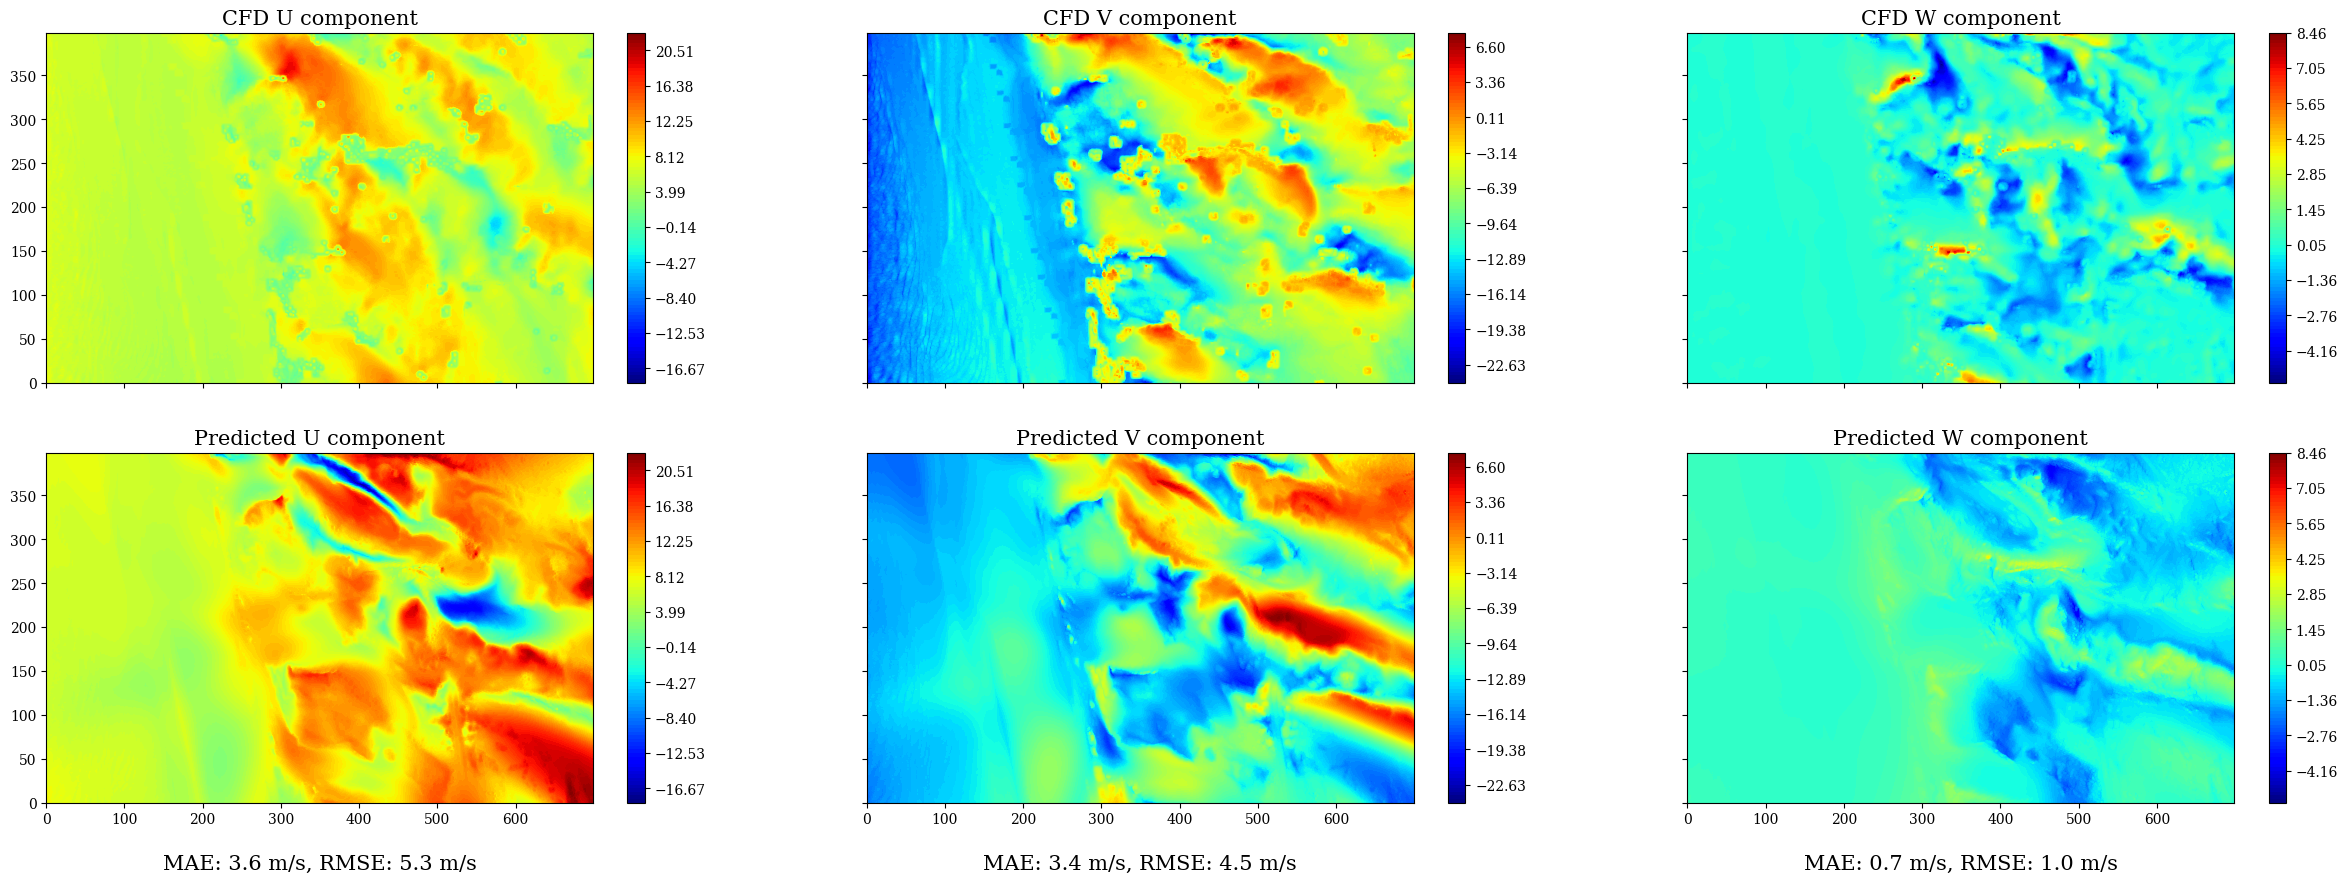

In [ ]:
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
#plt.figure(figsize=(14,4))

#get the preprocessed data and true U values
*preprocessed_data,  U_0, U_1, U_2, pressure, angle = get_preprocessed_data([0])
U_0, U_1, U_2, pressure = (i.reshape(shape) for i in (U_0, U_1, U_2, pressure))

u_pred, v_pred, w_pred, p_pred = FCNN.predict(*preprocessed_data, shape=shape)

u_levels = np.linspace(min(U_0.min(), u_pred.min()), max(U_0.max(), u_pred.max()), 100)
v_levels = np.linspace(min(U_1.min(), v_pred.min()), max(U_1.max(), v_pred.max()), 100)
w_levels = np.linspace(min(U_2.min(), w_pred.min()), max(U_2.max(), w_pred.max()), 100)

fig, axs = plt.subplots(2,3,  figsize=(30,10), sharex=True, sharey=True)
#fig.tight_layout()


## Truth Data
p1 = axs[0,0].contourf(U_0, levels=u_levels, cmap='jet')
fig.colorbar(p1, ax=axs[0,0])
axs[0,0].title.set_text('CFD U component')

p2 = axs[0,1].contourf(U_1, levels=v_levels, cmap='jet')
fig.colorbar(p2, ax=axs[0,1])
axs[0,1].title.set_text('CFD V component')

p3 = axs[0,2].contourf(U_2, levels=w_levels, cmap='jet')
fig.colorbar(p3, ax=axs[0,2])
axs[0,2].title.set_text('CFD W component')


## Error Data
U_error = U_0-u_pred
V_error = U_1-v_pred
W_error = U_2-w_pred
P_error = pressure-p_pred


u_err, v_err, w_err, p_err = np.mean(np.abs(U_error)), np.mean(np.abs(V_error)), np.mean(np.abs(W_error)), np.mean(np.abs(P_error))
u_rmse, v_rmse, w_rmse, p_rmse = np.sqrt(np.mean((U_error)**2)), np.sqrt(np.mean((V_error)**2)), np.sqrt(np.mean((W_error)**2)), np.sqrt(np.mean((P_error)**2))


## Prediction Data
p5 = axs[1,0].contourf(u_pred, levels=u_levels, cmap='jet')
fig.colorbar(p5, ax=axs[1,0])
axs[1,0].title.set_text('Predicted U component')

p6 = axs[1,1].contourf(v_pred, levels=v_levels, cmap='jet')
fig.colorbar(p6, ax=axs[1,1])
axs[1,1].title.set_text('Predicted V component')

p7 = axs[1,2].contourf(w_pred, levels=w_levels, cmap='jet')
fig.colorbar(p7, ax=axs[1,2])
axs[1,2].title.set_text('Predicted W component')

axs[1,0].set_xlabel('MAE: {:0.1f} m/s, RMSE: {:0.1f} m/s'.format(u_err, u_rmse), fontsize=15, labelpad=20)
axs[1,1].set_xlabel('MAE: {:0.1f} m/s, RMSE: {:0.1f} m/s'.format(v_err, v_rmse), fontsize=15, labelpad=20)
axs[1,2].set_xlabel('MAE: {:0.1f} m/s, RMSE: {:0.1f} m/s'.format(w_err, w_rmse), fontsize=15, labelpad=20)

#plt.savefig("PINN_neg70_deg_trained_angle.png", dpi=500)

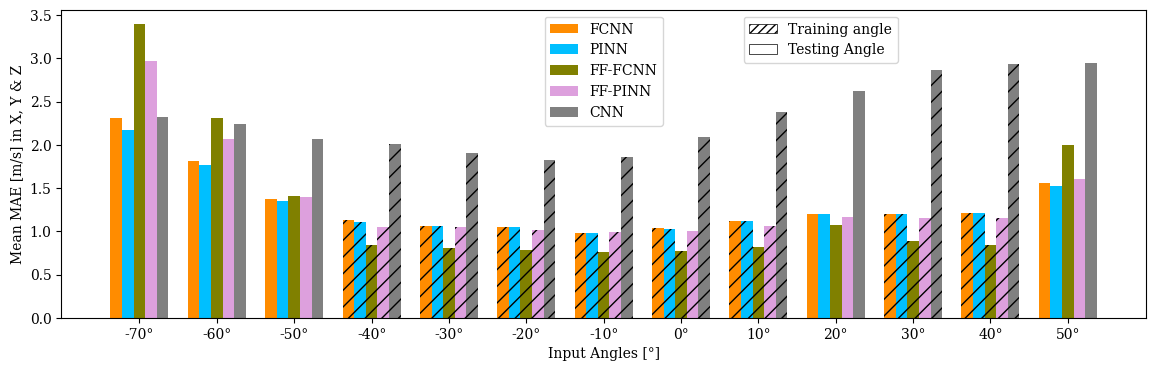

In [ ]:
from matplotlib.patches import Patch
categories = ['-70°', '-60°','-50°','-40°','-30°','-20°','-10°','0°','10°','20°','30°','40°','50°']
ind = np.arange(len(categories))

# Width of a bar
width = 0.15

# Create the bar plot
fig, ax = plt.subplots(figsize=[14,4])

# Bars for class 1
blue_indices = [0,1,2, 9, 12]

hatch = ['//' if i not in blue_indices else '' for i in range(len(categories))]
#hatch_physics = ['//' if i in blue_indices else '' for i in range(len(categories))]

bars1 = ax.bar(ind - width*2, FCNN_hist, width, color='darkorange', hatch=hatch)
bars2 = ax.bar(ind - width, PINN_hist, width, color='deepskyblue', hatch=hatch)
bars3 = ax.bar(ind, FF_FCNN_hist, width, color='olive', hatch=hatch)
bars4 = ax.bar(ind + width, FF_PINN_hist, width, color='plum', hatch=hatch)
bars5 = ax.bar(ind + width*2, thjis_model, width, color='grey', hatch=hatch)


# Add some text for labels, title and axes ticks
ax.set_xlabel("Input Angles [\N{DEGREE SIGN}]")
ax.set_ylabel("Mean MAE [m/s] in X, Y & Z")
#ax.set_title('Trained Models Comparison after 6k Epochs')
ax.set_xticks(ind)
ax.set_xticklabels(categories)


# Custom legend handles
legend_handles = [
    Patch(facecolor='darkorange', label='FCNN'),
    Patch(facecolor='deepskyblue', label='PINN'),
    Patch(facecolor='olive', label='FF-FCNN'),
    Patch(facecolor='plum', label='FF-PINN'),
    Patch(facecolor='grey', label='CNN')
]

# Add legend
legend1 = ax.legend(handles=legend_handles)


ax.add_artist(legend1)
legend_test_train = [
    Patch(facecolor='white', hatch='////', label='Training angle', edgecolor='black', linewidth=0.5),
    Patch(facecolor='white', hatch='', label='Testing Angle', edgecolor='black', linewidth=0.5),
]
# Add legend
legend2 = ax.legend(handles=legend_test_train,  loc='upper center', bbox_to_anchor=(0.7, 1.0))

plt.savefig("all_my_models_comparison.svg", dpi=300)